In [2]:
from __future__ import division
import warnings
warnings.filterwarnings('ignore')

Basic signal analysis and manipulation
============================

In [3]:
### import stuff
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact
from IPython import display
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
from scipy.fft import fft,fftfreq, ifft, fftshift, rfft
import scipy.signal as sg
fontP = FontProperties()
fontP.set_size('large')
plt.ion()
%matplotlib inline
plt.style.use('seaborn-poster')
rcParams["figure.figsize"] = [12, 8]


In [4]:
def sinef(duration,fs,f,A):
    dt = 1./fs
    t = np.arange(0,duration,dt)
    return (t,A*np.sin(f*2*np.pi*t))


In [5]:
#for future use    
duration = 2.25
fs=250 #sampling rate (in Hz)
dt = 1./fs
t = np.arange(0,duration,dt)
A=1
sine = lambda b,t: np.sin(b*2*np.pi*t)

> We are only touching some concepts of DSP to get you familiar with them. If you are interested in this topic, many reference books are available both as hard copies (e.g. [1](https://technion.primo.exlibrisgroup.com/permalink/972TEC_INST/q1jq5o/alma990022800990203971), [2](https://technion.primo.exlibrisgroup.com/permalink/972TEC_INST/17d0lpa/alma990021763400203971) ) and various online sources (e.g.[3](http://www.dspguide.com/pdfbook.htm)). 


### Fourier #2


```{admonition}
Lets talk a bit more about Fourier before moving forward. 

As you recall, we saw that for a rectangular pulse the tarnsformed function had non-zero values at many frequencies. 

What does it tell us if we wish to describe such a signal composed of a train of rectangular pulses using Fourier? 
```


To answer this question, we will now attempt to deconstruct a rectangular signal and then reconstruct it using just part of the frequencies. 

But first, recalling that most of our examples are given for real signals, let us rephrase the previsou equations. 

Assume we are looking at a signal $y(t)$, we already know that it can be written as :

```{math}
:label: Fser

& y(t) = \sum_n c_n \exp^{in\omega_0 t}

& c_n = \frac{1}{T}\int_{t_0}^{t_0+T}y(t)\exp^{-in\omega_0 t} dt
```

Next, using Euler's formula we can modify {eq}'Fser' such that 

```{math}
y(t) = \sum_n c_n \exp^{in\omega_0 t} = \sum_n c_n( \cos (n \omega_0 t) +i \sin (n \omega_0 t) )
```
After some more algebra, we can finally show that 

```{math}
y(t) = a_0 +\sum_{n>0} a_n \cos (n \omega_0 t) +b_n \sin (n \omega_0 t) )
```

and the series coefficients are given by:

$$
a_0 = \frac{1}{T}\int_{t_0}^{t_0+T} y(t) dt \\
a_n = \frac{2}{T}\int_{t_0}^{t_0+T} y(t) \cos (n \omega_0 t) dt \\
b_n = \frac{1}{T}\int_{t_0}^{t_0+T} y(t)  \sin (n \omega_0 t)  dt \\
$$

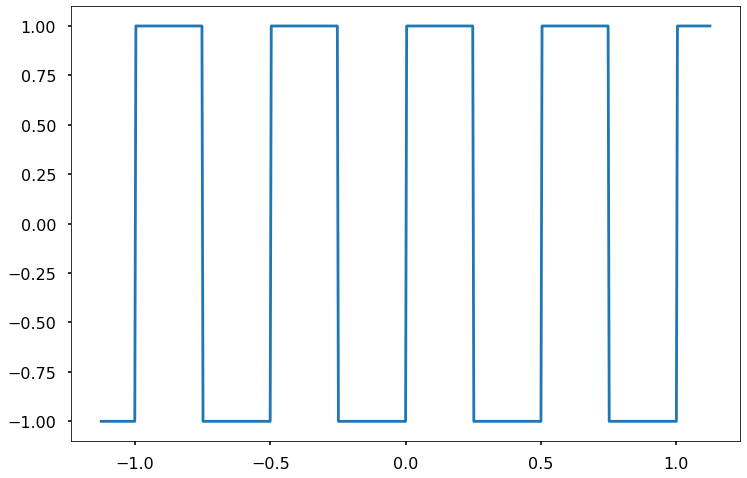

In [6]:
tsym = t-t.mean()
plt.plot(tsym,sg.square(2*np.pi*2*tsym))

The above function can be easily decomposed . 

Also, note that this is an odd function (with $T=0.5$) so it is expected that only $b_n$ will be non-zero, such that :

```{math}
y(t) = \sum_n b_n \sin ( \frac{n}{2} \pi t) )
```

and 

$$
b_n = \frac{1}{T}\int_{t_0}^{t_0+T} y(t)  \sin (n \omega_0 t)  dt = 
\begin{cases}
0 & \text{if n is even} \\
\frac{4}{n \pi}  & \text{if n is even} \end{cases}
$$

In [7]:
def term_n(n,t):
    bn = 2/(n*np.pi)
    yn = np.sin((4*np.pi*n)*t)
    return bn*yn

def reconstruct(Nterms):
    terms = np.arange(1,Nterms+1,1)
    duration = 2.25
    f=1000 #sampling rate (in Hz)
    dt = 1./f
    t = np.arange(0,duration,dt)
    t=t-t.mean()
    yr = np.zeros_like(t)
    for n in terms:
        if n%2>0:
            yr = yr + (4/(n*np.pi))* np.sin((4*np.pi*n)*t)
    yr_err=(sg.square(2*np.pi*2*t)-yr)
    fig, axs = plt.subplots(2,figsize=(12,8))
    axs[0].plot(t,sg.square(2*np.pi*2*t),lw=3,label='original signal')
    axs[0].plot(t,yr,lw=3,label='reconstructed signal',alpha=0.6)
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('y(t)')
    axs[0].legend(bbox_to_anchor=(1.25, 1),loc='upper right', prop=fontP)
    axs[1].plot(t,yr_err,lw=3)
    axs[1].set_ylim(-1,1)
    
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('error (absolute)')
    

NtermOp = [1,3,5,7,9,21,33,40]
interact(reconstruct, Nterms = NtermOp)


interactive(children=(Dropdown(description='Nterms', options=(1, 3, 5, 7, 9, 21, 33, 40), value=1), Output()),…

<function __main__.reconstruct(Nterms)>

#### distances in the frequency domain

When using the FFT algorithm of a signal it will often be convenient (or necessary) to artificially (or not) vary its length, we will devote the next few minutes to understand why.

Since we did not cover the inner-workings of the FFT algorithm, we shall only demonstrate this concept visually. 

As you recall from last week the DFT transform $X$ of a signal $x_n$ having a finite length can be obtained using:

$$
X = \sum_{n=-0}^{n=N-1} x[n]\exp\left ( -i\omega n \right )
$$

The obtained frequency sampling points are given by 

$$
\omega[k] = \frac{2 \pi}{N}k
$$

As a results, the number of points in the frequency domain $N$ will dictate the resolution we can obtain when trying to identify the frequencies of a signal using DFT. 

> remember that our sampling frequency also leads to a finite number of sampling points $N_s$

It seems like increasing $N$ will increase our resolution in the frequency domain.  Two common ways to address this are:

1. Zero padding (think about it as a kind of interpolation procedure)
2. Measure a longer signal (if you can..)

Lets look at the sum of two sine waves with close frequencies:

$$
s(t) = A_1\sin(2\pi f_1 t) + A_2 \sin(2\pi f_2 t)
$$


with $A_1 = 1$, $A_2 = 1$ and frequencies of $f_1 = 5$KHz and $f_2 = 5.05$KHz

We will sample our signal over $N_s = 1000$ points and a duration of $0.01 s$.

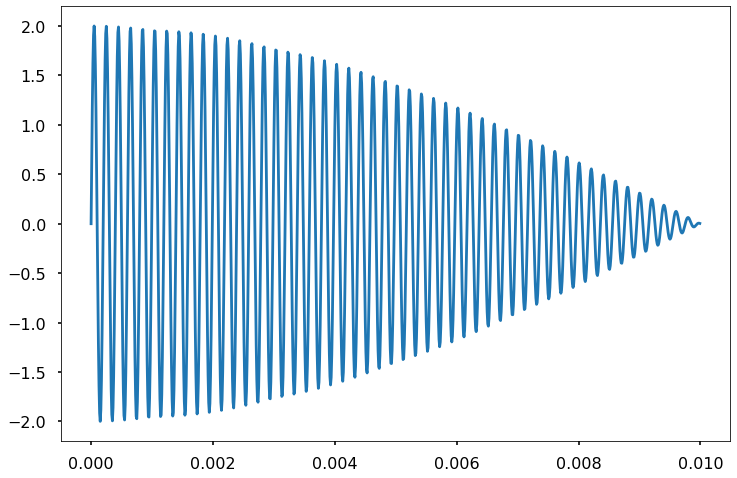

In [8]:
T = 0.01 #duration
f1, f2 = 5e3,5.05e3
Ns = 1000
t,s1 = sinef(T,Ns/T,f1,A)
t,s2 = sinef(T,Ns/T,f2,A)
s = s1 +s2
plt.plot(t,s)

Using the [FFT](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html#scipy.fft.fft) algorithm implemented in **scipy** we can easily choose the number of points in the frequency domain (and thus its resolution). 

- when no number of points is given the function will use $N=N_s$. 
- when $N>N_s$ is given as an input, the function will use zero padding.
- when $N<N_s$ is used, only the first $N$ points of the signal will be trasnformed.

Let us examine the three cases:

In [9]:
dt=T/s.size
S1 = (np.abs(fft(s)))
S2 = (np.abs(fft(s,int(Ns*10))))
S3 = (np.abs(fft(s,int(Ns*0.5))))
xf1=fftfreq(S1.size,dt)
xf2=fftfreq(S2.size,dt)
xf3=fftfreq(S3.size,dt)

#S1=20*np.log10(2*S1/S1.size)
#S2=20*np.log10(2*S2/S1.size)
#S3=20*np.log10(2*S3/S1.size)

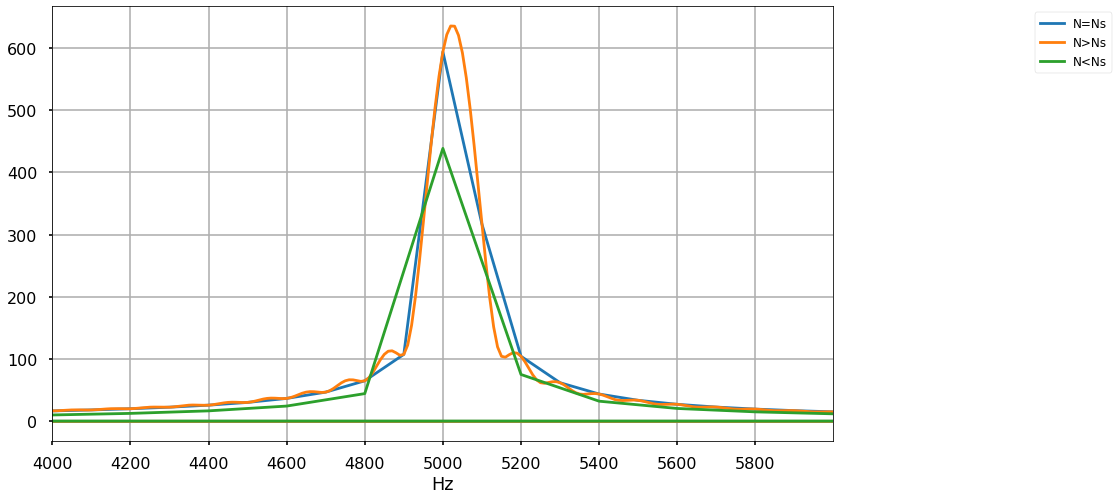

In [10]:
fig,axs = plt.subplots(figsize=(14,8))
axs.plot(xf1,(S1),label='N=Ns')
axs.plot(xf2,(S2),label='N>Ns')
axs.plot(xf3,(S3),label='N<Ns')
axs.set_xlim([4e3,6e3])
#axs.set_ylim([-30,5])
axs.set_xlabel('Hz')

axs.legend(bbox_to_anchor=(1.25, 1),loc='upper left', prop=fontP)
axs.grid()
axs.set_xticks(np.arange(4e3,6e3,200));

**So what just happend?**

We have added zeros (lots of them) to the signal and yet still can not detect the two frequencies. 

Looking closly at the <span style='color:#ff8c00'> orange </span> line we can see "*wiggles*" every $100Hz$ since our signals are only $50Hz$ apart, it is evident that the sinc functions representing them will not be able to capture that regardless of how many zeros we will add. 

Next, lets examine what happens if we change the length of our signal - In other words lets make our measurement longer.


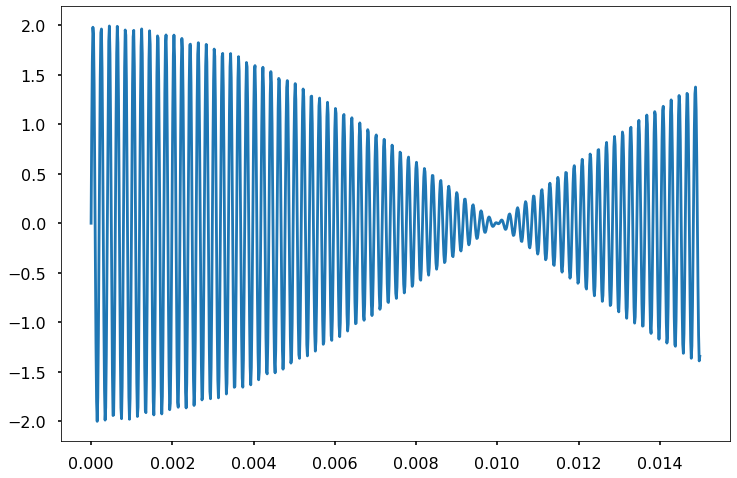

In [11]:
T = 0.015 #duration
f1, f2 = 5e3,5.05e3
Ns = 1000
t,s1 = sinef(T,Ns/T,f1,A)
t,s2 = sinef(T,Ns/T,f2,A)
sl = s1 +s2
plt.plot(t,sl)

In [12]:
sl.size

1000

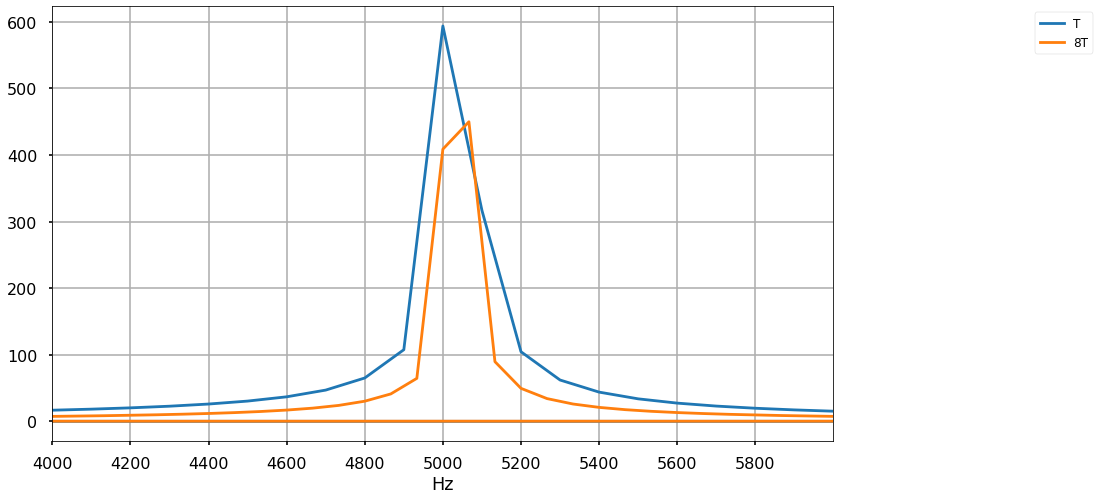

In [13]:
dt=T/sl.size
SL = (np.abs(fft(sl)))
xfL=fftfreq(SL.size,dt)
#SL=(2*SL/SL.size)
fig,axs = plt.subplots(figsize=(14,8))
axs.plot(xf1,(S1),label='T')
axs.plot(xfL,(SL),label='8T')
axs.set_xlim([4e3,6e3])
#axs.set_ylim([-30,5])
axs.set_xlabel('Hz')

axs.legend(bbox_to_anchor=(1.25, 1),loc='upper left', prop=fontP)
axs.grid()
axs.set_xticks(np.arange(4e3,6e3,200));

**So how do we approach FFT?**

1. choose the signal duration such that $1/T$ will be smaller than the difference between frequencies you wish to detect. 
2. Make sure $N$ is at the very least equal to $N_s$.
3. Many of the FFT algorithms will work faster in $N=2^n$. keep it in mind/
4. make sure to have $N$ large enough such that the frequencies of interest will not be projected onto multiple points.
5. zero padding can help but its not a magic solution.

#### RMS

A signal's root mean square value (RMS) is defined as :


```{math}
y_{RMS} = \sqrt{ \frac{1}{t_1-t_0} \int_{t_0}^{t_1}y(t)^2dt }
```

For a purely AC signal, having a zero mean, the RMS value serves as a statistical measure for the magnitude of fluctuations.  


In [14]:
duration = 2.25
f=1000 #sampling rate (in Hz)
dt = 1./f
t = np.arange(0,duration,dt)
sine = lambda b,t: np.sin(b*2*np.pi*t)

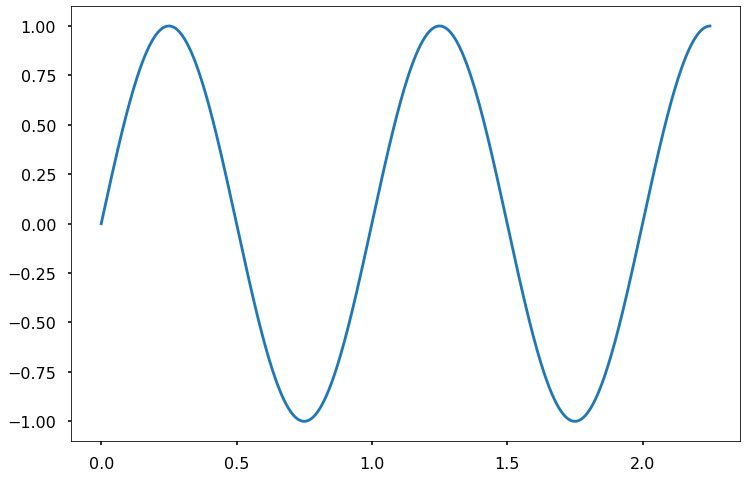

In [15]:
y = 1*sine(1,t)
plt.plot(t,y)
plt.show()

In [16]:
ymean = np.sum(y)/len(t)
yrms = np.sum(np.power(y,2))
yrms = np.sqrt(yrms/len(t))

print('the RMS value is ',yrms,'and the mean value is',ymean)

the RMS value is  0.7069496288829762 and the mean value is 0.0705130753301223


#### Averaging

Consider a periodic signal with some noise and a drift

we wish to see how can avaraging help us clean the signal (and at what price)


<function matplotlib.pyplot.show(close=None, block=None)>

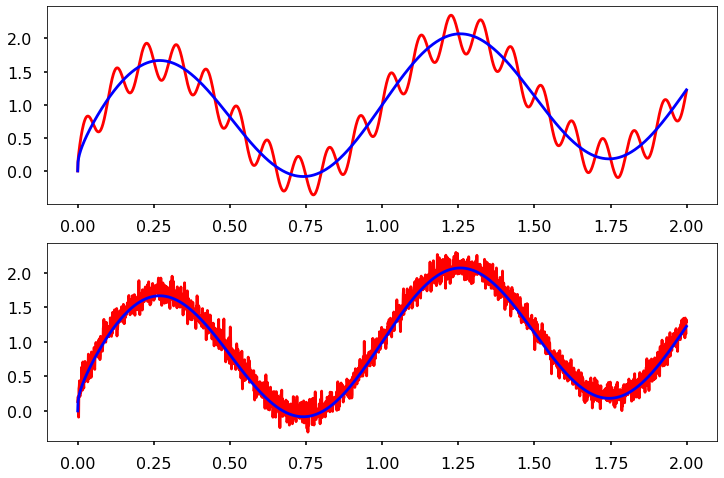

In [17]:
#create a signal

duration = 2
t = np.arange(0,duration,dt)
Signal = 1*sine(1,t)+np.power(t,0.3)
#make some noise

N = Signal.shape[0]
sigma = 0.1; mu=0.05
Noise = sigma*np.random.randn(N)+mu
Osci  =0.3*sine(10,t)

#Construct the new signals
Signal_noisy = Signal+Noise
Signal_Osci = Signal+Osci
fig,axs = plt.subplots(2,figsize=(12,8))
axs[0].plot(t,Signal_Osci,'r-',t,Signal,'b-')
axs[1].plot(t,Signal_noisy,'r-',t,Signal,'b-')
plt.show

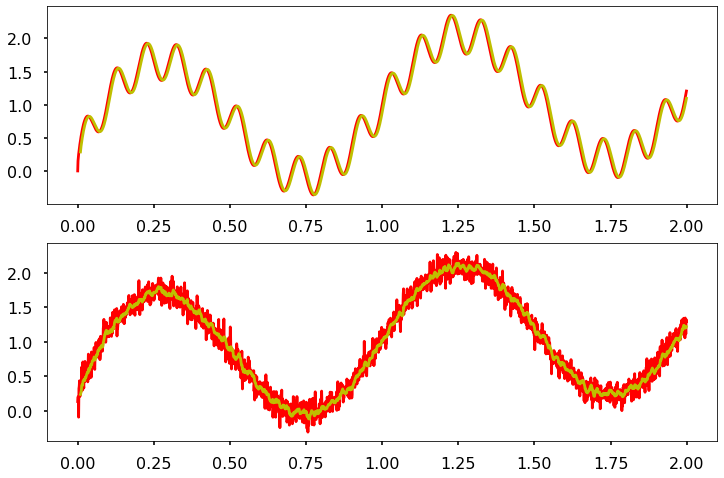

In [18]:
def movingaverage (Sn,So, window):
    weights = np.ones(window)/window
    Mavgn = np.convolve(Sn, weights, 'valid')
    Mavgo = np.convolve(So, weights, 'valid')
    t1 = t[len(t)-len(Mavgo):]
    fig,axs = plt.subplots(2,figsize=(12,8))
    axs[0].plot(t,So,'r-', t1,Mavgo,'y-',)
    axs[1].plot(t,Sn,'r-',t1,Mavgn,'y-',)
    
    
window_size = np.array([2,5,10,25,100,500])

movingaverage(Signal_noisy,Signal_Osci,10)


```{note}
What has happened? 

Can you explain why the periodic noise did not budge while the white noise seems ti decrease in amplitude?
```

#### Finite Impluse Response (FIR ) with a triangular window

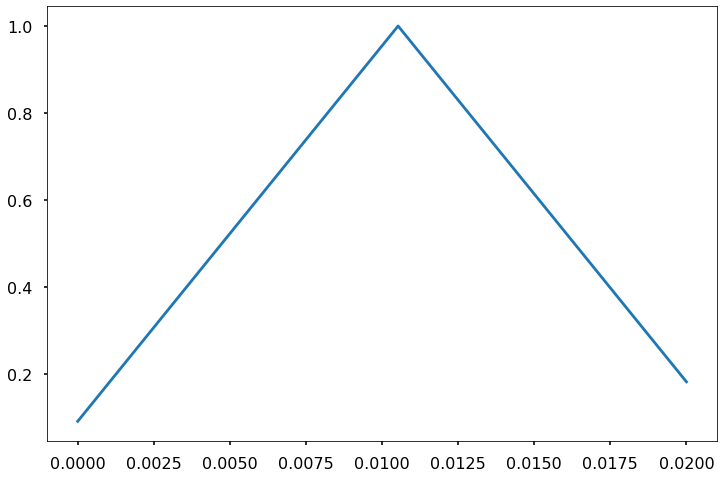

In [19]:
h = sg.get_window('triang', 20)
xh=np.linspace(0,(len(h))*dt,len(h))
plt.plot(xh,h)


In [20]:
import pandas as pd
#re arrange the data
Allsignals = np.vstack((Signal, Signal_noisy, Signal_Osci))
SignalNoise_df = pd.DataFrame(columns = ['Signal','signal with white noise','signal with periodic noise'],
                              data= Allsignals.T, index=t)
SignalNoise_df.head(3)

Signal  signal with white noise  signal with periodic noise
0.000  0.000000                 0.135946                    0.000000
0.001  0.132176                 0.202891                    0.151013
0.002  0.167558                 0.194546                    0.205158

In [21]:
#define a filter and plot filteres signal and original noisy signal
import scipy.signal as sg

def FIR_Triangle (signals, length,t):
    h = sg.get_window('triang', length)
    fil = sg.convolve(signals, h / h.sum())
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    #plotting the noisy signal
    signals.plot(ax=ax, lw=3)
    # ... and the filtered signal.
    ax.plot(t, fil[:len(signals)],
             '-r', lw=2)
    return

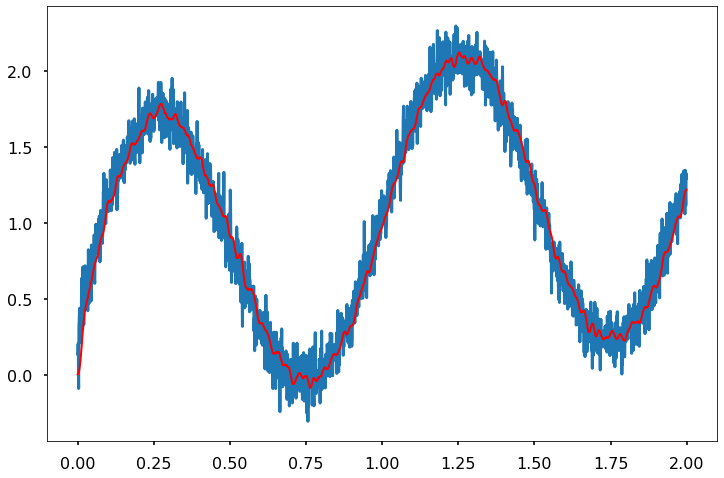

In [22]:
#Length of triangle for the FIR
Length = 20
#run filter and plot
FIR_Triangle (SignalNoise_df['signal with white noise'], Length,t)

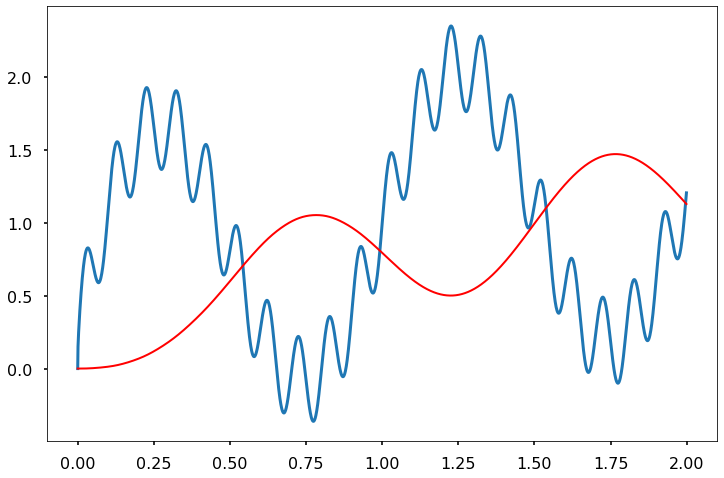

In [23]:
FIR_Triangle (SignalNoise_df['signal with periodic noise'], 1/(dt),t)

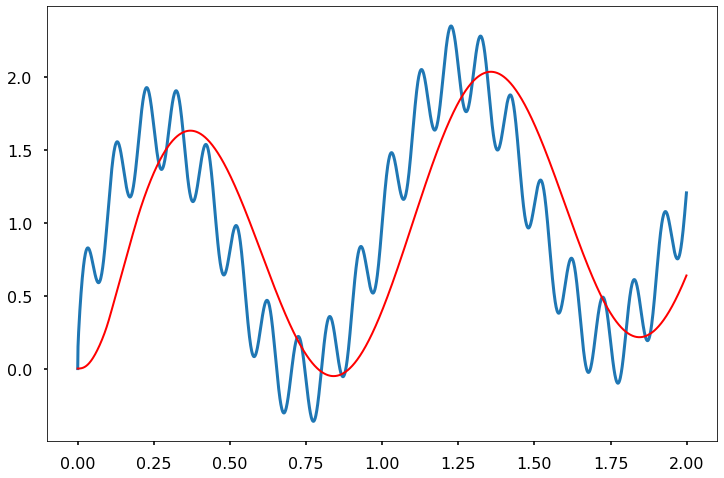

In [24]:
FIR_Triangle (SignalNoise_df['signal with periodic noise'], 1/(5*dt),t)

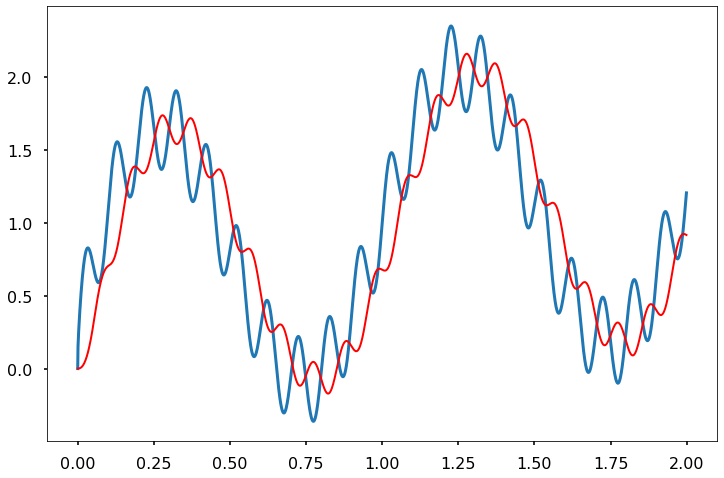

In [25]:
FIR_Triangle (SignalNoise_df['signal with periodic noise'], 1/(10*dt),t)

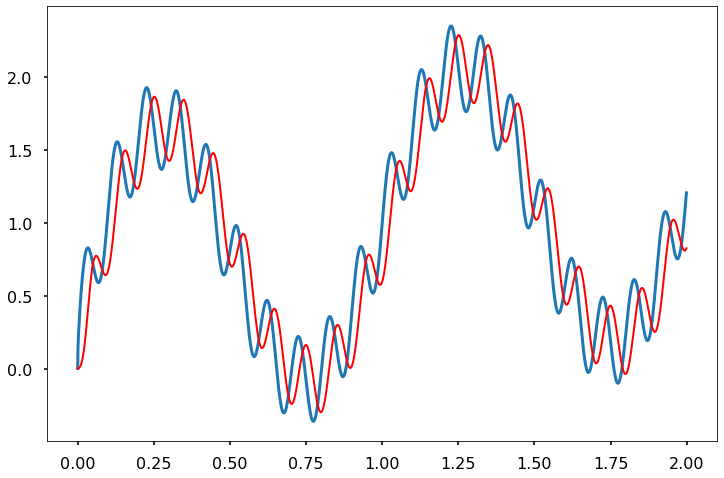

In [26]:
FIR_Triangle (SignalNoise_df['signal with periodic noise'], 1/(20*dt),t)

#### Filtering by frequencies

We already saw that Fourier transform can be used to remove some of the frequencies in the signal. 
Lets examine how that can be used to filter out our signals using three seperate filters:

-**Low-pass filter** - we will remove all of the frequencies above a certain $f_{\text{max}}$

-**High-pass filter** - we will remove all of the frequencies below a certain $f_{\text{min}}$

-**Band-pass filter** - we will remove all of the frequencies outside a certain range $(f_{\text{min}},f_{\text{max}})$

We can use a hard cutoff (a step function) or allow for some smooth transition in the frequency domain:

In [27]:
def Simple_filt(t,signal, fmin, fmax,Type):
    xfilt=fftfreq(len(signal),dt)
    Y=fft(signal)
    cleaned_Y=Y.copy()
    cleaned_Y[np.abs(xfilt)<fmin]=0
    cleaned_Y[np.abs(xfilt)>fmax]=0
    y_filt = ifft(cleaned_Y)
    fig,ax = plt.subplots(figsize=(12,8))
    ax.plot(t,signal,'red',lw=4,label='original signal')
    ax.plot(t,y_filt,'go',alpha=0.2,label='filtered signal')
    ax.set_title(str(Type))
    ax.set_xlabel('time')
    ax.set_ylabel('y(t)')
    ax.legend(bbox_to_anchor=(1.25, 1),loc='upper left', prop=fontP)

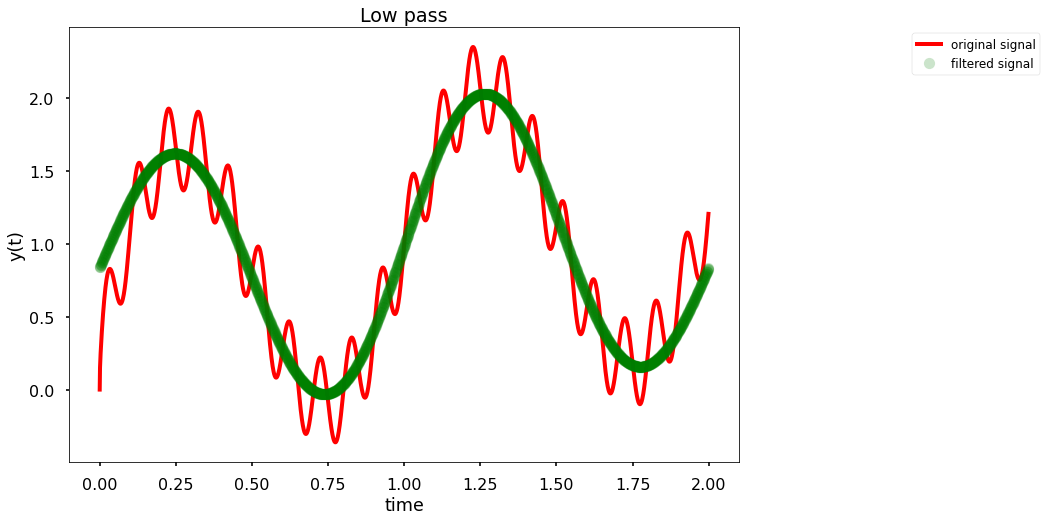

In [28]:
Simple_filt(t,Signal_Osci, -np.inf, 1,'Low pass')

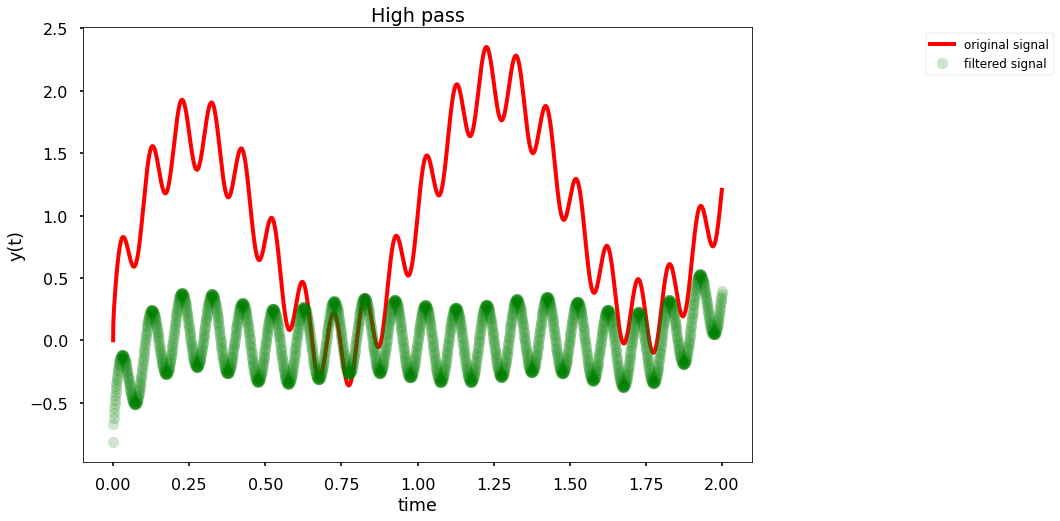

In [29]:
Simple_filt(t,Signal_Osci, 2, np.inf,'High pass')

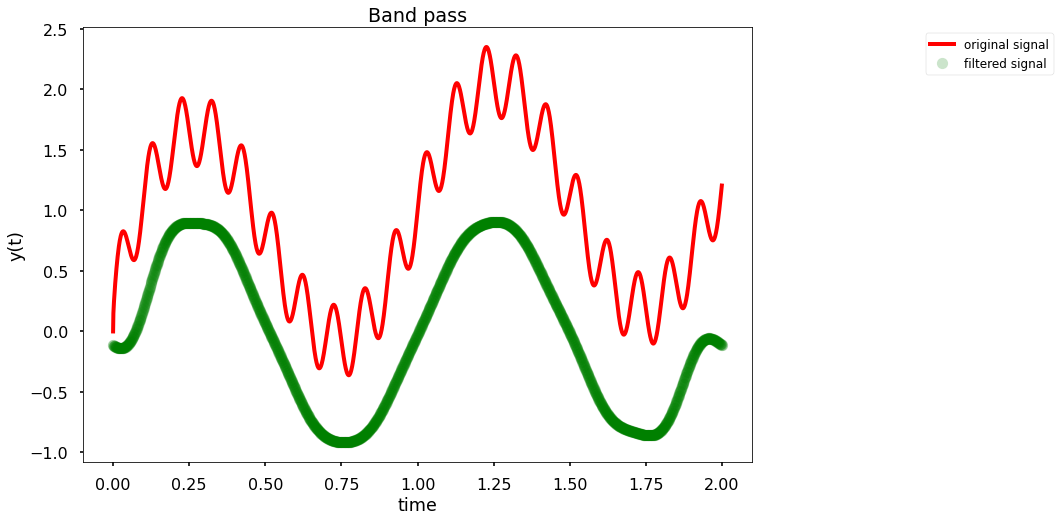

In [30]:
Simple_filt(t,Signal_Osci, 1, 5,'Band pass')

Now lets see how we can do it in a nicer (less brute-force) way 

We will use a Butterworth filter to control the rate at which frequencies are removed


In [31]:
HighFreq = 1000 ;LowFreq = 1/1000 ; order=4
def Bfilt(HighFreq,LowFreq,order,func):
    freqs=[LowFreq,HighFreq]
    b, a = sg.butter(order, freqs, str(func), analog=True)
    w, h = sg.freqs(b, a)
    plt.plot(w, 20 * np.log10(abs(h)))
    plt.xscale('log')
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude change [dB]')
    plt.xlim(LowFreq/10,HighFreq*10)
    plt.ylim(-30,5)
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(LowFreq, color='green') # cutoff frequency
    plt.axvline(HighFreq, color='green') # cutoff frequency
    plt.show()
    return()

funcs=[ 'bandpass', 'bandstop']
orders = [1,2,3,4,5,10,15,30]
interact(Bfilt,HighFreq=(0,1000,2),LowFreq=(1/500,50,1/500),order=orders,func=funcs)

interactive(children=(IntSlider(value=500, description='HighFreq', max=1000, step=2), FloatSlider(value=25.0, …

<function __main__.Bfilt(HighFreq, LowFreq, order, func)>

decibels (dB) are used to express the ratio between two values.

For the case above, we wish to see what is the ratio between the amplitude of each frequency after passing through our filter, with respect to its input amplitude. 

Since dB are defined as ratios of power we can right it as:

$$
10 \log \left( \frac{A_{filt}^2}{A_{in}^2}\right)=20\,log\left(\frac{A_{filt}}{A_{in}}\right)$$  

And hence:
- a 50 percent decrease in power (amplitude) is ~ -3dB (-6dB)
- a tenfold decrease in power is ~ -10dB (-20dB)


In [136]:

HighFreq = 1000 ;LowFreq = 1/1000 ; order=4
def Bfilt(HighFreq,LowFreq,order,func):
    freqs=[LowFreq,HighFreq]
    b, a = sg.butter(order, freqs, str(func), analog=True)
    w, h = sg.freqs(b, a)
    fig,axs = plt.subplots(2,figsize=(12,7))
    axs[0].plot(w, 20 * np.log10(abs(h)))
    axs[0].set_xscale('log')
    axs[0].set_title('Butterworth filter frequency response')
    axs[0].set_xlabel('Frequency [radians / second]')
    axs[0].set_ylabel('Amplitude change [dB]')
    axs[0].set_xlim(1e-3,1e4)
    axs[0].set_ylim(-30,5)
    axs[0].grid(which='both', axis='both')
    axs[0].axvline(LowFreq, color='green') # cutoff frequency
    axs[0].axvline(HighFreq, color='green') # cutoff frequency
    
    axs[1].plot(w,np.angle(h))#np.unwrap(ang ))
    axs[1].set_xscale('log')
    axs[1].set_title('Butterworth filter phase response')
    axs[1].set_xlabel('Frequency [radians / second]')
    axs[1].set_ylabel('phase [rad]')
    axs[1].set_xlim(1e-3,1e4)
    #axs[1].set_ylim(-180,180)
    axs[1].grid(which='both', axis='both')
    axs[1].axvline(LowFreq, color='green') # cutoff frequency
    axs[1].axvline(HighFreq, color='green') # cutoff frequency
    fig.tight_layout(pad=3.0)
    return()

funcs=[ 'bandpass', 'bandstop']
orders = [1,2,3,4,5,10,15,30]
interact(Bfilt,HighFreq=(0,1000,2),LowFreq=(1/100,50,1/500),order=orders,func=funcs)

interactive(children=(IntSlider(value=500, description='HighFreq', max=1000, step=2), FloatSlider(value=25.004…

<function __main__.Bfilt(HighFreq, LowFreq, order, func)>

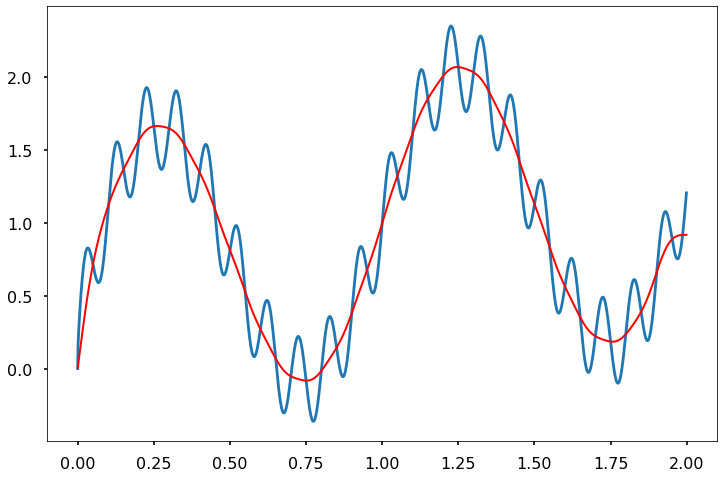

In [85]:
def plot_filt_sig(signal,t,freq,order,btype):
    b, a = sg.butter(order, freq,str(btype))
    plt.plot(t, signal)
    plt.plot(t, sg.filtfilt(b, a, signal), 
             '-r', lw=2)
plot_filt_sig(Signal_Osci,t,1/80,4,'low')